Min velocity: 1028.00  Max velocity 4500.00
dz,dx,dt (m): 4.11199951171875 4.11199951171875 0.0005815245477944201
Model dimension [nz,nx,nt]:  201 601 2000


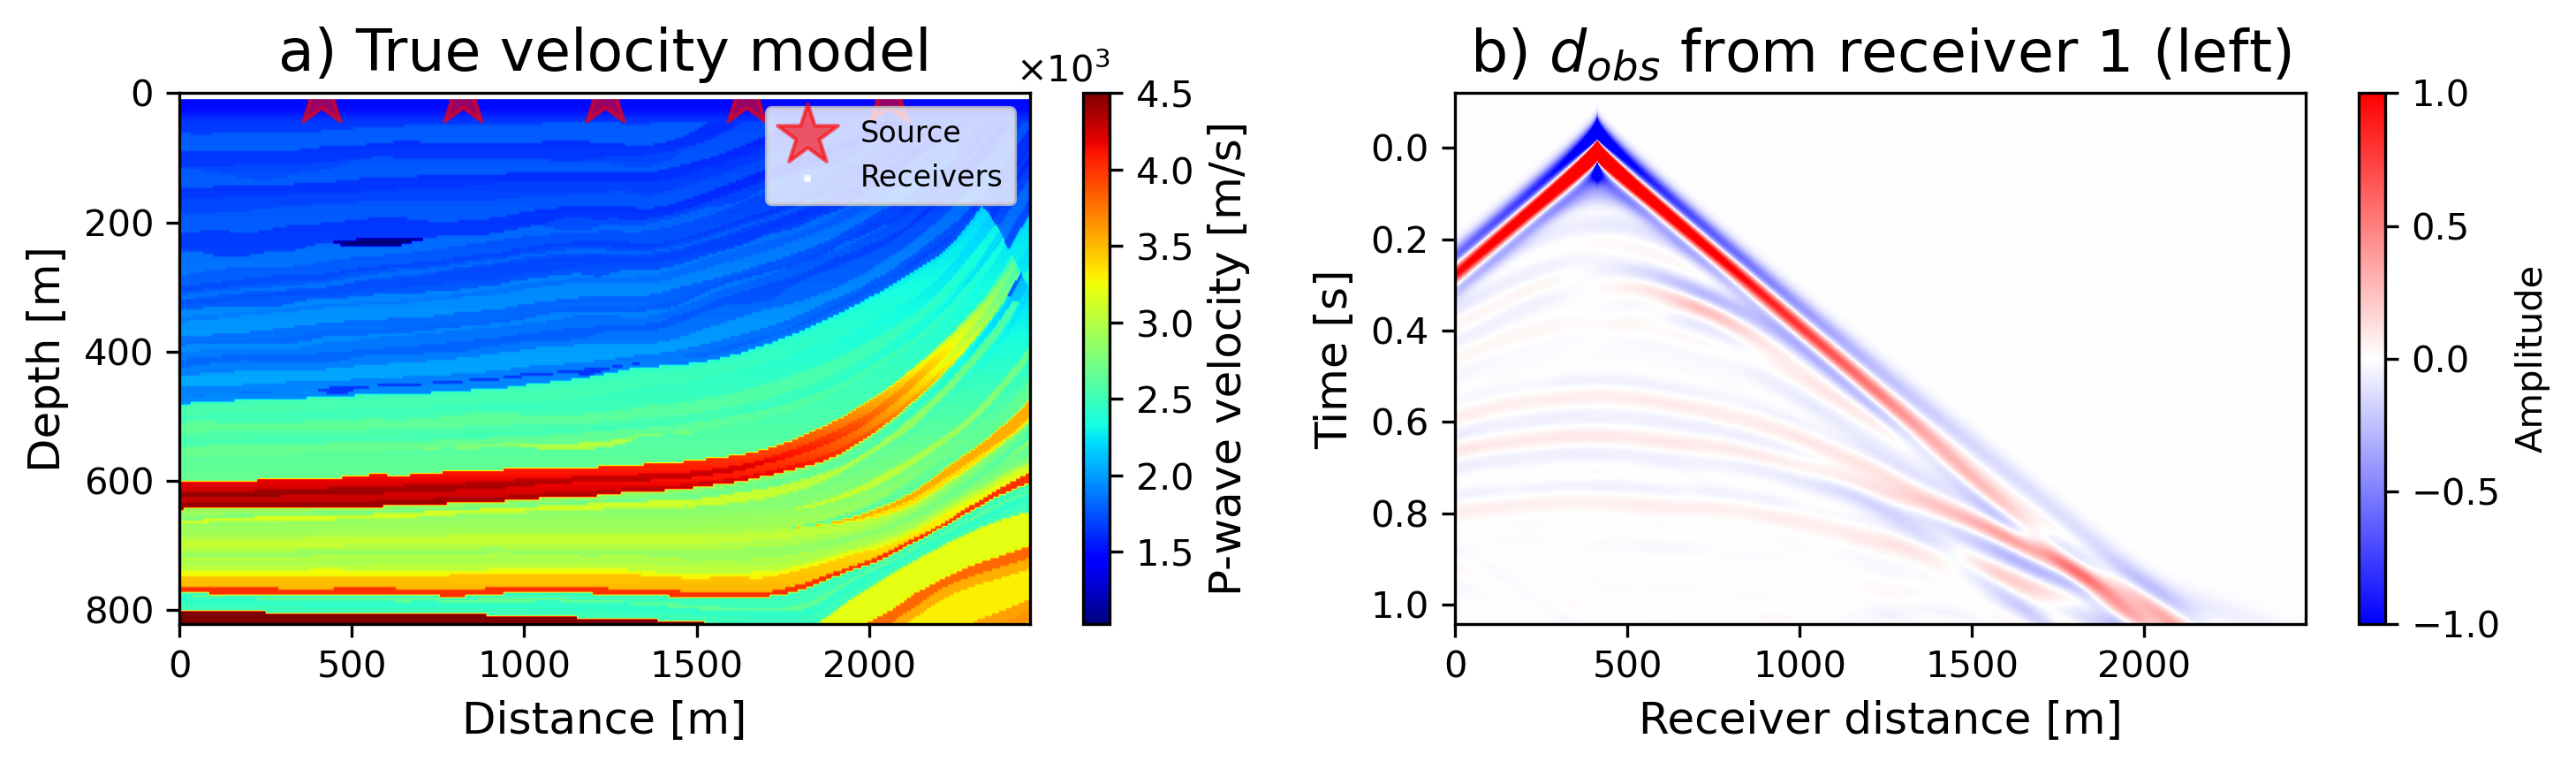

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from IPython.display import clear_output
import numpy as np
import cupy as cp
import cupyx
import scipy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import time
labelsize = 16

from func.propagation_matrix import defmodel, extend_model
from func.velocity_model import gaussian2d
from joblib import Parallel, delayed

precision = np.float64
device = 'cpu'

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v


def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(len(receivers_width), zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(len(receivers_width), nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_height, np.full(len(receivers_height), zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_height, np.full(len(receivers_height), nx-zxsrc[0]-1))) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
    zxrec = zxrec1

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec, indices = np.unique(zxrec,return_index=True,axis=1)

  return zxrec[:, np.argsort(indices)]


def extend_model(v,nz,nx,next):
	"""
	Extension of the model (to limit the edge effects)
	"""
	vel = v.reshape((nz,nx))
	nze  = nz + 2*next
	nxe  = nx + 2*next
	vele = np.zeros([nze,nxe], dtype=precision)
	# Central part
	vele[next:nze-next,next:nxe-next] = vel
	# Top and bottomB
	for ix in range(next,nxe-next):
		for iz in range(next):
			vele[iz,ix]       = vel[0,ix-next]
			vele[nze-1-iz,ix] = vel[nz-1,ix-next]
	# Left and right
	for ix in range(next):
		for iz in range(next,nze-next):
			vele[iz,ix]       = vel[iz-next,0]
			vele[iz,nxe-1-ix] = vel[iz-next,nx-1]
	# Corners
	for ix in range(next):
		for iz in range(next):
			vele[iz,ix]             = vel[0,0]
			vele[nze-1-iz,ix]       = vel[nz-1,0]
			vele[iz,nxe-1-ix]       = vel[0,nx-1]
			vele[nze-1-iz,nxe-1-ix] = vel[nz-1,nx-1]
	return vele.flatten()


def prop2d(wsrc, zxsrci, zxrec, vel, at, az, ax, next, device='cpu'):
	"""
	2d wave propagation with multiple sources
	"""
	
	if device=='cpu':
		"""
		2d wave propagation
		Resolution with finite differences
		Orders 2 in time and space
		with absorbing boundaries (Clayton and Engquist)
		Vectorial implementation (much faster)
		"""
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		nze = nz + 2 * next2
		nxe = nx + 2 * next2
		size = nze * nxe

		# Calculate source waveform
		wsrc = np.array([wsrc]) if wsrc.ndim == 1 else np.array(wsrc) # convert source wavelet from 1d to 2d
		zxsrci = np.array(zxsrci) # source location to array

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,nz,nx,next2)
		vele = vele.flatten()

		# Center Part (Laplacian)
		mask0 = np.full((nze, nxe), False)
		mask0[1+nabs:-1-nabs,1+nabs:-1-nabs] = True
		mask0 = mask0.flatten()

		# Construct the Laplacian matrix
		fact = (dt * vele)**2

		# Initialize arrays
		diagonal = np.zeros(size)
		off_diagonal_x_left = np.zeros(size)
		off_diagonal_x_right = np.zeros(size)
		off_diagonal_z_left = np.zeros(size)
		off_diagonal_z_right = np.zeros(size)

		# Set values for interior points
		diagonal[mask0] = (2*np.ones(size) + fact*(-2*np.ones(size)*(_dz2+_dx2)))[mask0]
		off_diagonal_x_left[mask0] = (fact*np.ones(size) * _dz2)[mask0]
		off_diagonal_x_right[mask0] = (fact*np.ones(size) * _dz2)[mask0]
		off_diagonal_z_left[mask0] = (fact*np.ones(size) * _dx2)[mask0]
		off_diagonal_z_right[mask0] = (fact*np.ones(size) * _dx2)[mask0]

		# Calculate factors for boundary conditions
		factz = (-dt/dz) * vele
		factx = (-dt/dx) * vele

		# Bottom part
		mask1 = np.full((nze, nxe), False)
		mask1[nze-1-nabs:nze,:nxe] = True
		mask1 = mask1.flatten()
		diagonal[mask1] = 1 + factz[mask1]
		off_diagonal_z_left[mask1] = -factz[mask1]

		# Top part
		mask2 = np.full((nze, nxe), False)
		mask2[:1+nabs,:nxe] = True
		mask2 = mask2.flatten()
		diagonal[mask2] = 1 + factz[mask2]
		off_diagonal_z_right[mask2] = -factz[mask2]

		# Right part
		mask3 = np.full((nze, nxe), False)
		mask3[:nze,nxe-1-nabs:nxe] = True
		mask3 = mask3.flatten()
		diagonal[mask3] = 1 + factx[mask3]
		off_diagonal_x_left[mask3] = -factx[mask3]

		# Left part
		mask4 = np.full((nze, nxe), False)
		mask4[:nze,:1+nabs]  = True
		mask4 = mask4.flatten()
		diagonal[mask4] = 1 + factx[mask4]
		off_diagonal_x_right[mask4] = -factx[mask4]

		# Construct the sparse Laplacian matrix
		A = sp.diags([off_diagonal_x_left[1:], off_diagonal_z_left[nxe:], diagonal, off_diagonal_z_right, off_diagonal_x_right],
								[-1, -nxe, 0, nxe, 1], shape=(size, size), format='csr')

		# Wavefield p mask (initial center part)
		maskp = np.full((nze, nxe), 0)
		maskp[next+nabs:nze-next-nabs,next+nabs:nxe-next-nabs]  = 1
		maskp = maskp.flatten()

		pm = np.zeros(size) # Previous wave field
		pt = np.zeros(size)
		pp = np.zeros(size)

		p = [np.zeros(nz*nx)]
		p.append(np.zeros(nz*nx))

		srcsteps = wsrc.shape[1] # Determine the time steps of the source
		for it in range(1,nt-1): # From 1 to nt-1
			pm = pt.copy()
			pt = pp.copy()
			# pp = A.dot(pt) - pm*mask0 + pwsrc[:,it]*fact*mask0
			if it<srcsteps:
				cen = np.zeros((nz,nx))
				cen[zxsrci[0,:], zxsrci[1,:]] = wsrc[:,it]
				asrcit = np.pad(cen, next2, mode='constant').flatten()
				srcterm = asrcit*fact*mask0
			else: srcterm = np.zeros(size)

			pp = A.dot(pt) - pm*mask0 + srcterm
			p.append(pp[maskp==1])

		p = np.moveaxis(np.array(p), 0, -1)
		d_obs = p.reshape((nz,nx,nt))[zxrec[0], zxrec[1], :]

	return p, d_obs

def second_order_derivative_cpu(p, at, az, ax):
	"""
	Calculate second order derivative for p(z,x,t)
	method: finite-difference
	"""
	# extend model to tmin=0 tmax=0 -- insert zeros in dimension t
	nz, nx = len(az), len(ax)
	dt = at[1] - at[0]
	# Modify p array in-place without copying
	p[:, 0] = 0.0
	p[:, -1] = 0.0
	_dt2 = 1./dt**2
	# Calculate second order derivative using vectorized operations
	p_dt_dt = (p[:, :-2] - 2 * p[:, 1:-1] + p[:, 2:]) * _dt2
	# Insert zeros at boundaries using array views
	p_dt_dt = np.concatenate([np.zeros((nz*nx, 1)), p_dt_dt, np.zeros((nz*nx, 1))], axis=1)

	return p_dt_dt

def J(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	nz, nx = len(az), len(ax)
	if vel.ndim == 1: vel = np.reshape(vel.flatten(),(nz,nx))
	_, d = prop2d(wsrc,zxsrc,zxrec,vel,at,az,ax,next,device)
	residual = d - d_obs
	J = 0.5 * np.sum(residual ** 2) # Residual is the half of the L2 norm square
	print("J = %.2f" % J)
	global loss
	loss = J.copy()

	return J

def gradient(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	"""
	Calculate gradiant using adjoint state method
	"""
	p_fwd, d = prop2d(wsrc,zxsrc,zxrec,vel,at,az,ax,next,device)
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back, _ = prop2d(np.flip(residual,axis=1), zxrec, zxsrc, vel, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=1)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative_cpu(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/vel**3  * np.sum(p_back * p_dt_dt, axis=1) # G.shape = (201,201)
	
	return G.flatten()

def gradient_multi(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	"""
	Calculate gradiant using adjoint state method
	"""
	nsrc = zxsrc.shape[1]
	grads = np.zeros_like(vel)
	for i in range(nsrc):
		print('Source', i, end='...   ')
		zxsrci = np.expand_dims(zxsrc[:,i],-1)
		p_fwd, d = prop2d(wsrc,zxsrci,zxrec,vel,at,az,ax,next,device)
		residual = d - d_obs[i] # residual shape (n_rec, nt) - residual.shape=(5,801)
		# Calculate back propagated p_back(z,x,t)
		p_back, _ = prop2d(np.flip(residual,axis=1), zxrec, zxsrc, vel, at, az, ax, next, device)
		p_back = np.flip(p_back,axis=1)
		# Calculate second order time derivative of p_fwd(z,x,t)
		p_dt_dt = second_order_derivative_cpu(p_fwd, at, az, ax)
		# Calculate gradiant
		grad = 2/vel**3  * np.sum(p_back * p_dt_dt, axis=1) # G.shape same as vel
		grads += grad

	return grads.flatten()

def gradient_par(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	nsrc = zxsrc.shape[1]
	grads = Parallel(n_jobs=nsrc)(delayed(gradient)
			       (vel,d_obs,wsrc,np.expand_dims(zxsrc[:,i],-1),zxrec,at,az,ax,next,device) 
			        for i in range(nsrc))
	
	return sum(grads).flatten()

def readbin(flnam,nz,nx):
    # Read binary file (32 bits)
    with open(flnam,"rb") as fl:
        im = np.fromfile(fl, dtype=np.float32)
    im = im.reshape(nz,nx,order='F')
    return im

# Initialize the model axis az, ax, at
nz,nx,nt = 201,601,2000
vmin,vmax = 1000,4500
izsrc, ixsrc = [1], [300]
next = 100

# Read the original input data
vel   = readbin('../dataset/marm2_sel.dat',nz,nx)
v_ref = vel * 1e3
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

# v_ref, Q = gaussian2d(ranges = [50,600], param=1.,nx=[nz,nx], variance=500, mu=2750)
v_init = 2750 * np.ones(nz*nx)
vmin,vmax = v_ref.min(),v_ref.max()

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
# receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
# 							np.arange(zxsrc[1][0],nx,interv)) #right
receivers_width = np.arange(0,nx)
receivers_height = np.arange(izsrc[0],nz-izsrc[0],interv) # down
zxrec = receiver_position(1)

zxsrc = np.array([[1,1,1,1,1], [nx//6,2*nx//6,3*nx//6,4*nx//6,5*nx//6]])
nsrc = zxsrc.shape[1]
d_obs = []
for i in range(nsrc):
	zxsrci = np.expand_dims(zxsrc[:,i],-1)
	p, d_obs_i = prop2d(wsrc,zxsrci,zxrec,v_ref.reshape(nz,nx),at,az,ax,next,device)
	d_obs.append(d_obs_i)

plt.figure(figsize=(10,3), dpi=300)
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
cbar = plt.colorbar()
cbar.formatter.set_useMathText(True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
cbar.update_ticks()
cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
plt.legend(loc='upper right',fontsize=labelsize-8)
plt.xlabel('Distance [m]', fontsize=labelsize-4)
plt.ylabel('Depth [m]', fontsize=labelsize-4)
plt.title("a) True velocity model",fontsize=labelsize)

plt.subplot(1,2,2)
plt.imshow(d_obs[0].T,cmap='bwr',vmin=-1,vmax=1,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
cbar = plt.colorbar()
cbar.set_label("Amplitude")
plt.title("b) $d_{obs}$ from receiver 1 (left)", fontsize=labelsize)
plt.xlabel('Receiver distance [m]', fontsize=labelsize-4)
plt.ylabel('Time [s]', fontsize=labelsize-4)
plt.tight_layout()
plt.show()


In [6]:
# optimize function
v_smo = readbin('../dataset/marm2_smo.dat',nz,nx)
v_init = (v_smo * 1e3).flatten()
g = gradient_multi(v_init.flatten(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)

Source 0...   

## Inversion

### Standard FWI


At iterate   67    f=  7.37145D+02    |proj g|=  8.55370D-03


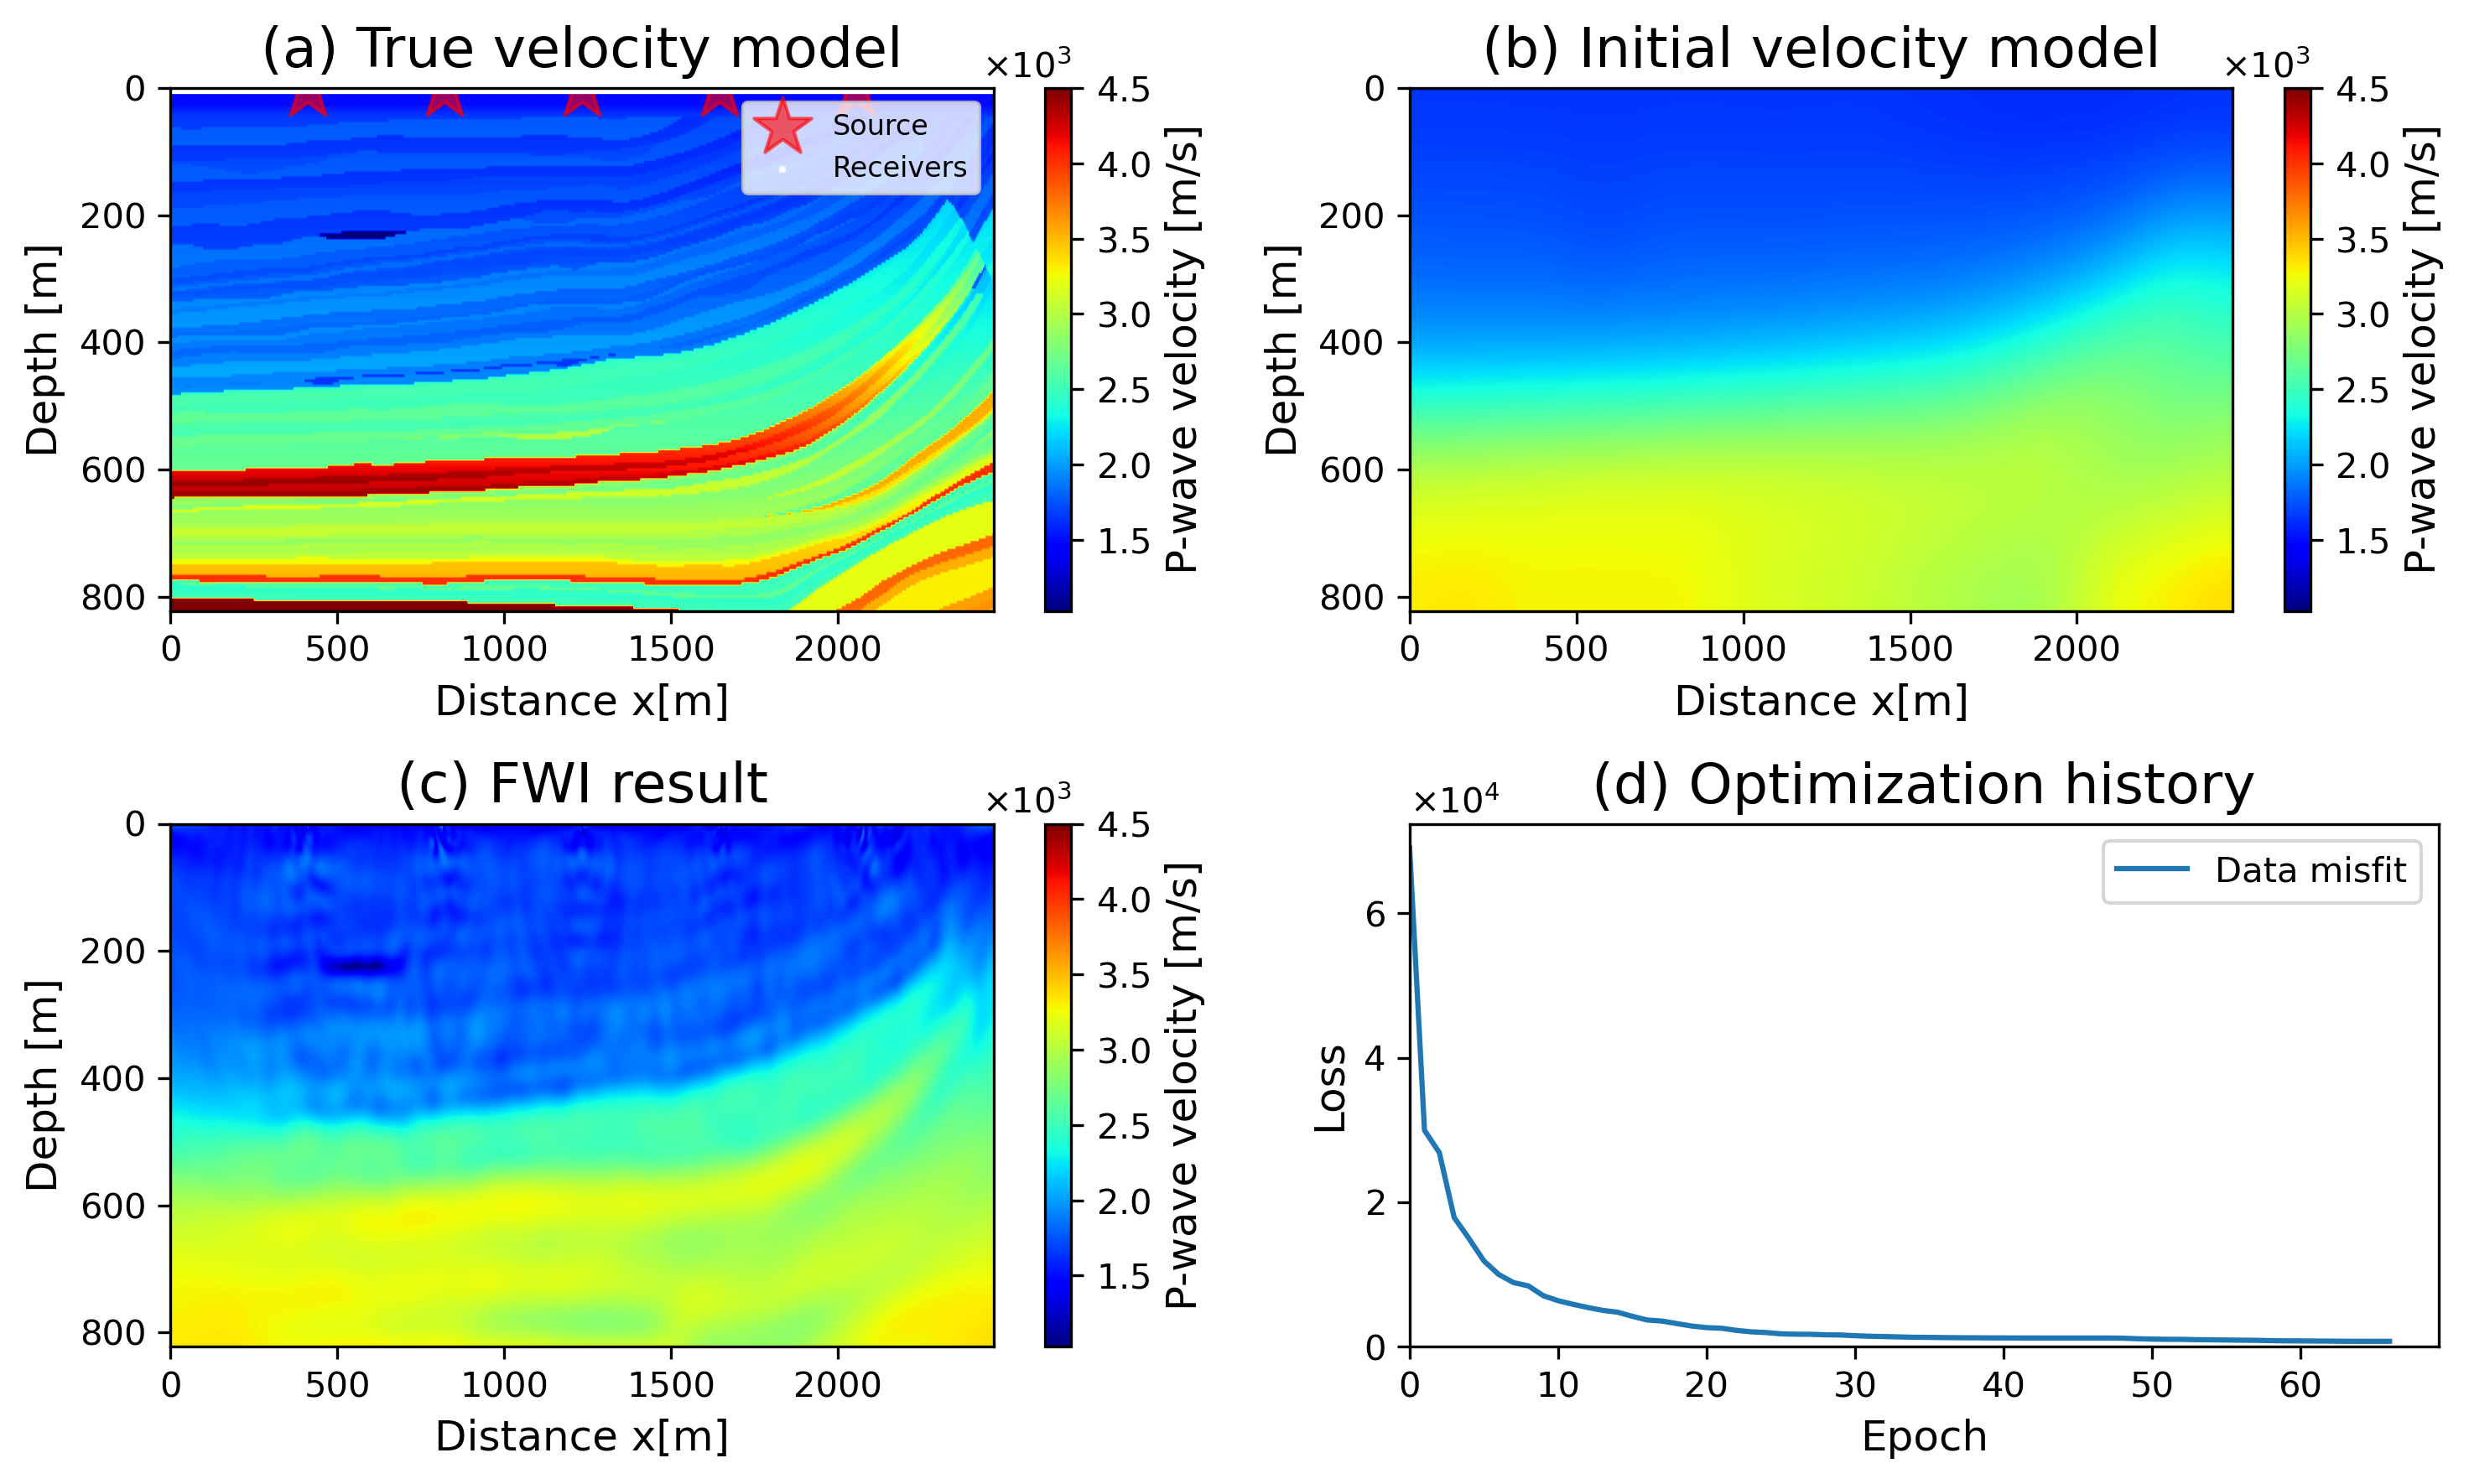

J = 1000.81
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   J = 737.15
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   J = 736.75
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   J = 736.71
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   J = 736.96
Source 0...   Source 1...   

In [5]:
from scipy.optimize import minimize

# optimize function
v_smo = readbin('../dataset/marm2_smo.dat',nz,nx)
v_init = (v_smo * 1e3).flatten()

def J_multi(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	
    nsrc = zxsrc.shape[1]
    Js = 0
    for i in range(nsrc):
        zxsrci = np.expand_dims(zxsrc[:,i],-1)
        nz, nx = len(az), len(ax)
        if vel.ndim == 1: vel = np.reshape(vel.flatten(),(nz,nx))
        _, d = prop2d(wsrc,zxsrci,zxrec,vel,at,az,ax,next,device)
        residual = d - d_obs[i]
        J = 0.5 * np.sum(residual ** 2) # Residual is the half of the L2 norm square
        Js += J

    print("J = %.2f" % Js)
    global loss
    loss = Js.copy()

    return Js

def callback(x):
    clear_output(wait=True)
    losses.append(loss)

    plt.figure(figsize=(10,6), dpi=300)
    # Plot the true velocity
    plt.subplot(221)
    plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
    plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
    plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
    plt.legend(loc='upper right',fontsize=labelsize-8)
    plt.xlabel('Distance x[m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(a) True velocity model",fontsize=labelsize)

    # Plot the initial velocity
    plt.subplot(222)
    plt.imshow(v_init.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
    plt.xlabel('Distance x[m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(b) Initial velocity model",fontsize=labelsize)

    # Display current velocity field
    plt.subplot(223)
    plt.imshow(x.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
    plt.xlabel('Distance x[m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(c) FWI result",fontsize=labelsize)

    # Display loss track
    plt.subplot(224)
    plt.plot(losses,lw=1.5)
    # Set the x-axis tick formatter to scientific notation
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2,2))  # Adjust these limits as needed
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.legend(['Data misfit'])
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.xlabel('Epoch', fontsize=labelsize-4)
    plt.ylabel('Loss', fontsize=labelsize-4)
    plt.title("(d) Optimization history",fontsize=labelsize)

    plt.tight_layout()
    plt.show()

zxsrc = np.array([[1,1,1,1,1], [nx//6,2*nx//6,3*nx//6,4*nx//6,5*nx//6]])
losses = []
resi = minimize(fun = J_multi, 
               x0 = v_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device),
               method='L-BFGS-B', 
               # method='Newton-CG',
               bounds = np.full((len(v_init), 2), (vmin,vmax)),
               jac = gradient_multi, # Jacobian
               options = {'disp':True, 'maxiter':150},
               callback = callback
              )
v_fwi = resi.x
print(v_fwi.shape)

### Prior inversion

Max: 3737.122056928308 Min: 1206.9472378981163


Text(0.5, 1.0, 'Prior Sample')

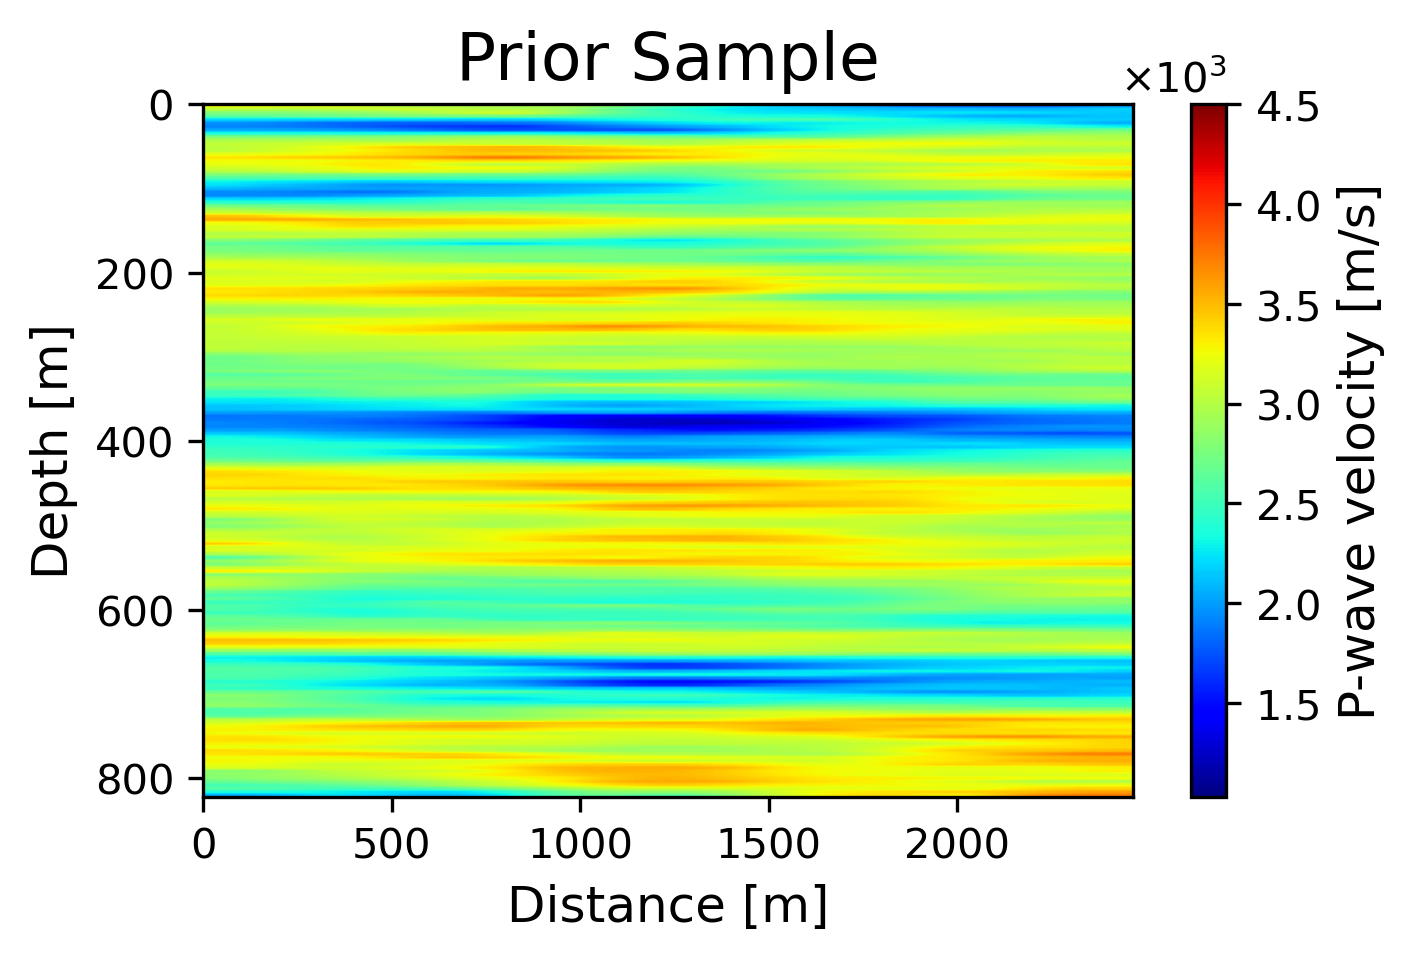

In [2]:
simu, Q = gaussian2d(ranges = [10,600], param=1.,nx=[nz,nx], variance=900, mu=(vmin+vmax)/2)
print("Max:",simu.max(),"Min:",simu.min())

plt.figure(figsize=(5,3),dpi=300)
plt.imshow(simu,vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
cbar = plt.colorbar()
cbar.formatter.set_useMathText(True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
cbar.update_ticks()
cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
plt.xlabel('Distance [m]', fontsize=labelsize-4)
plt.ylabel('Depth [m]', fontsize=labelsize-4)
plt.title("Prior Sample",fontsize=labelsize)

At iterate   64    f=  2.06966D+03    |proj g|=  2.24011D-02


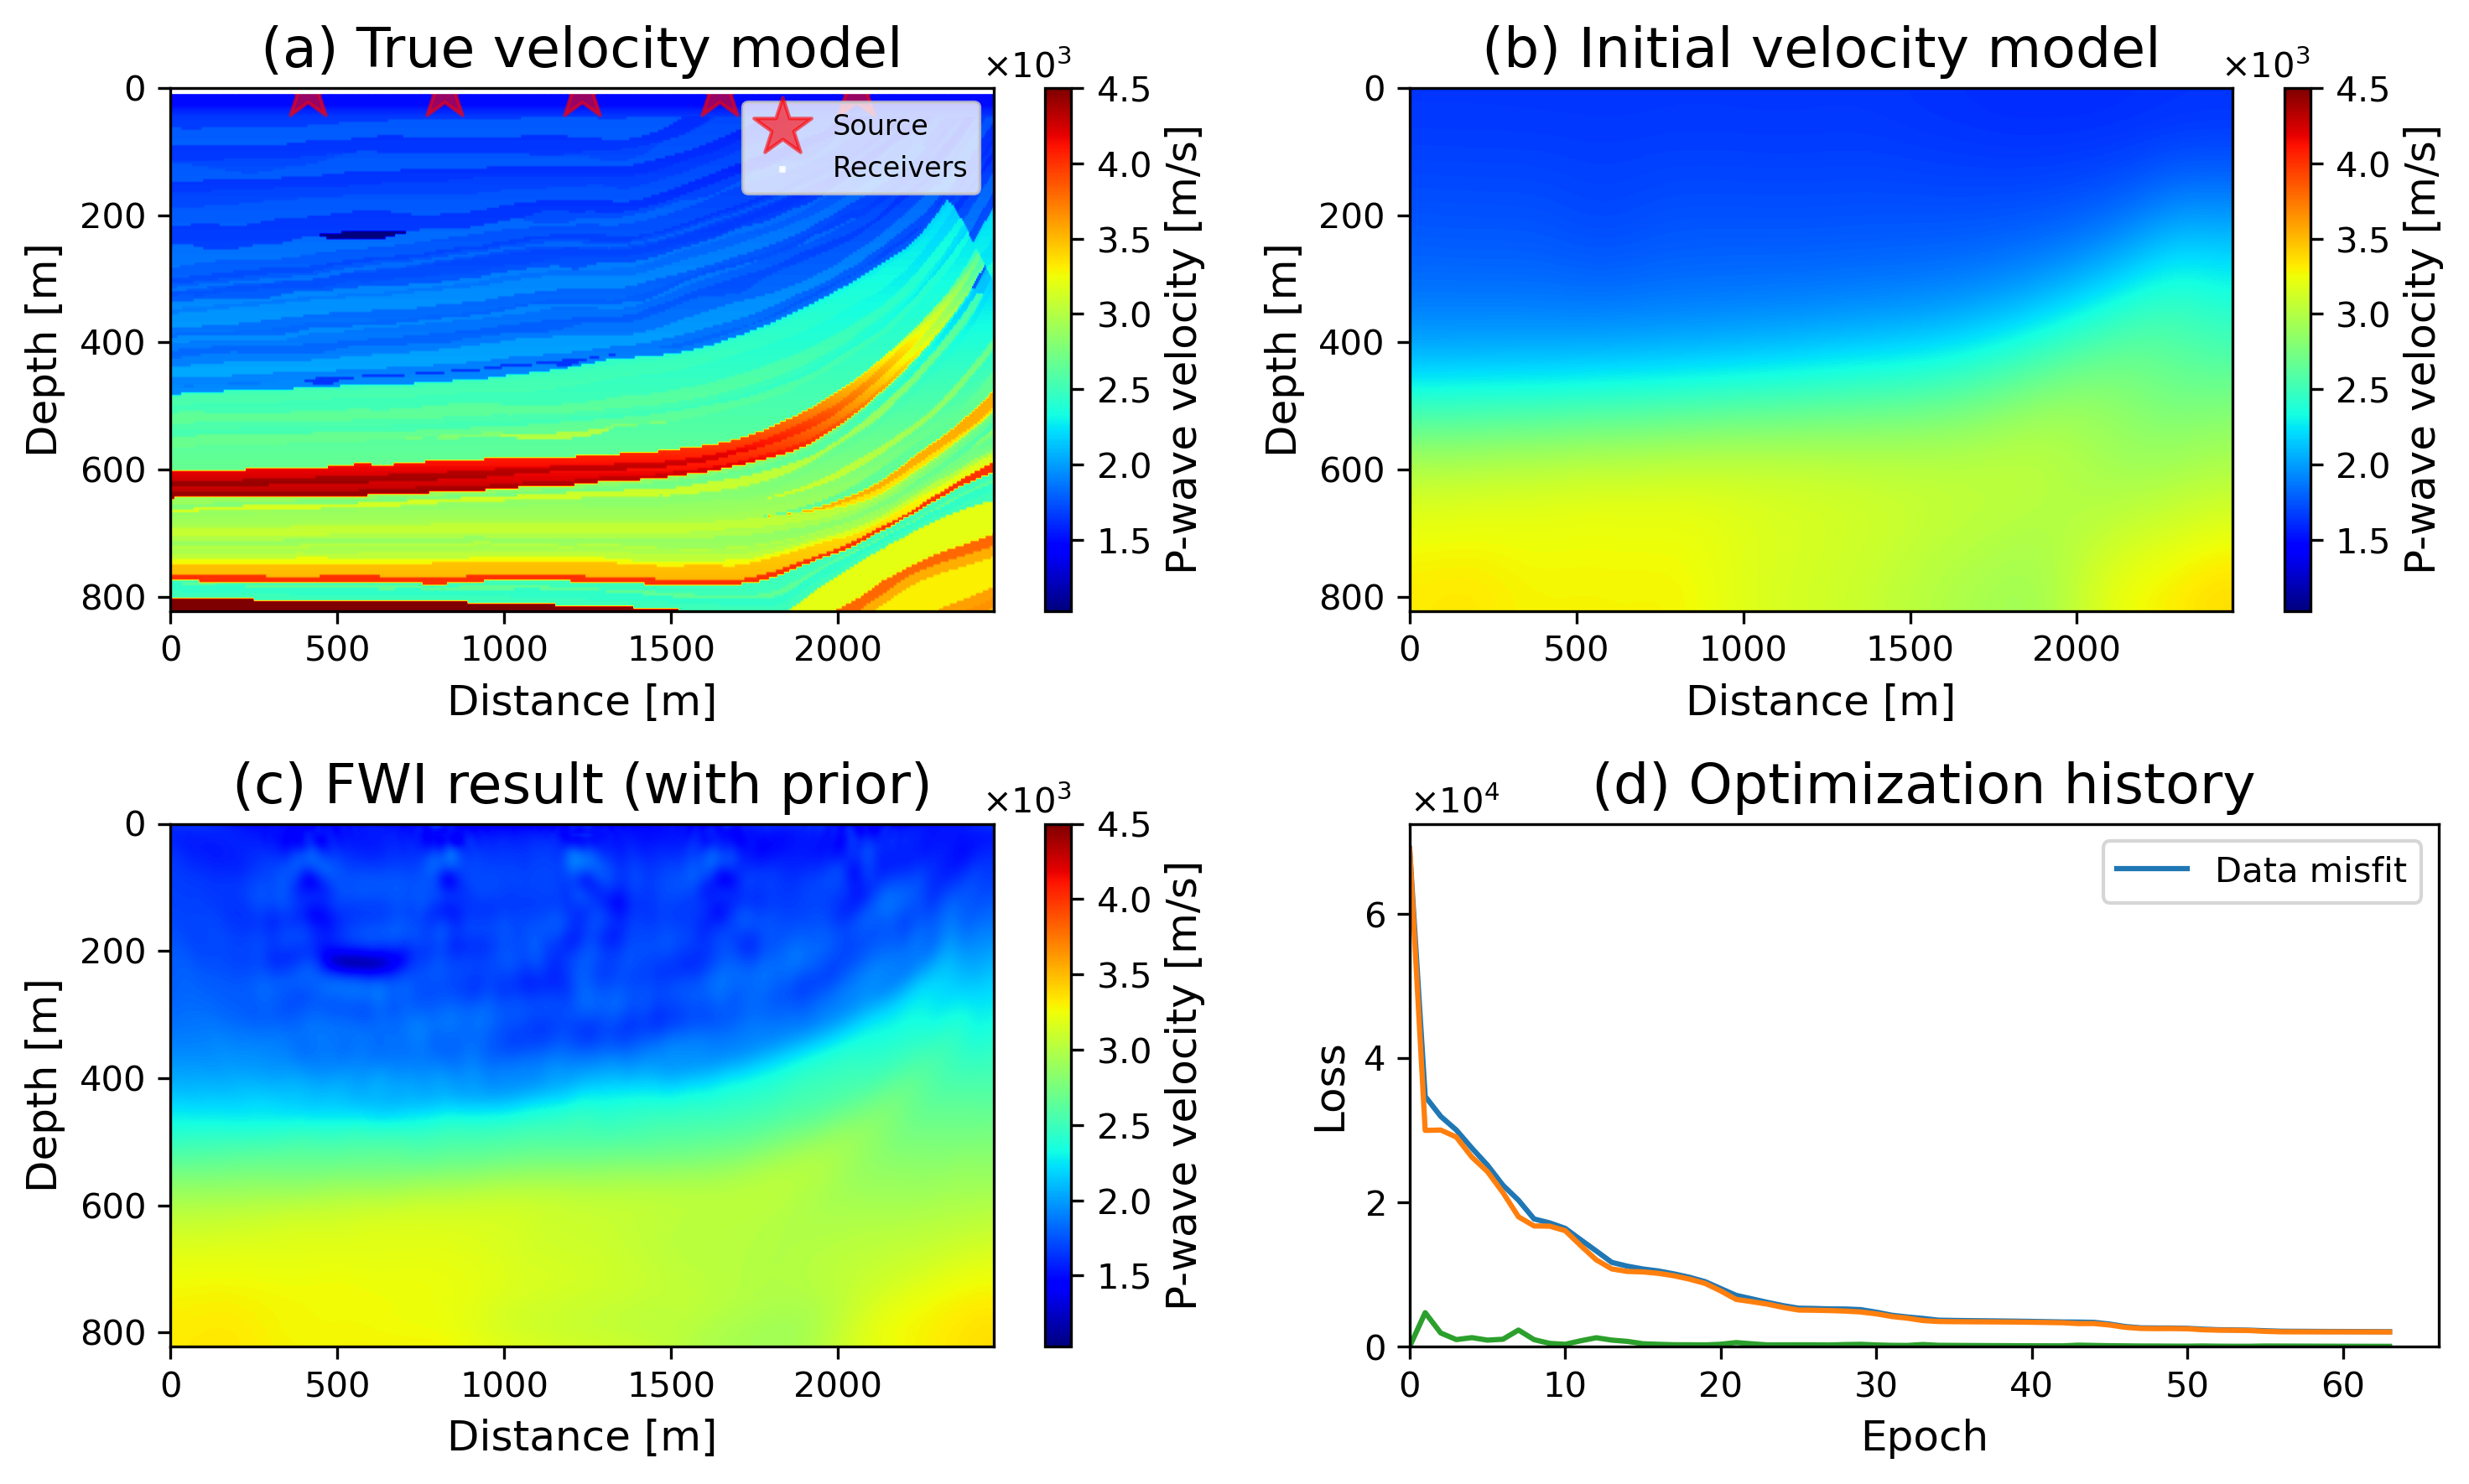

Loss (J) = 1981.0265 Penalty term = 115.4899 Total loss = 2096.5164 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 1998.6918 Penalty term = 48.4305 Total loss = 2047.1223 
Source 0...   

KeyboardInterrupt: 

In [3]:
from func.velocity_model import gaussian2d

def J_prior(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	nsrc = zxsrc.shape[1]
	Js = 0
	for i in range(nsrc):
			zxsrci = np.expand_dims(zxsrc[:,i],-1)
			nz, nx = len(az), len(ax)
			if vel.ndim == 1: vel = np.reshape(vel.flatten(),(nz,nx))
			_, d = prop2d(wsrc,zxsrci,zxrec,vel,at,az,ax,next,device)
			residual = d - d_obs[i]
			J = 0.5 * np.sum(residual ** 2) # Residual is the half of the L2 norm square
			Js += J
	print("Loss (J) = %.4f " % Js, end='')
	vel = vel.flatten()
	# penalty = .5 * vel.T.dot(Q.toarray()).dot(vel)
	penalty = nsrc * 0.5 * vel.T.dot(Q.dot(vel)) * alpha
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = Js + penalty
	print("Total loss = %.4f " % loss)
	# Save history
	global current_loss
	current_loss = np.array([loss,Js,penalty])

	return loss

def gradiant_prior_multi(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# grad = gradient_par(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
	nsrc = zxsrc.shape[1]
	grad = gradient_multi(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)

	return grad.flatten() + nsrc*Q.dot(vel.flatten())*alpha

# Record loss history over each iterations
def callback(x):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])
	clear_output(wait=True)

	plt.figure(figsize=(10,6), dpi=300)
	# Plot the true velocity
	plt.subplot(221)
	plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
	plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
	plt.legend(loc='upper right',fontsize=labelsize-8)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("(a) True velocity model",fontsize=labelsize)

	# Plot the initial velocity
	plt.subplot(222)
	plt.imshow(v_init.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("(b) Initial velocity model",fontsize=labelsize)

	# Display current velocity field
	plt.subplot(223)
	plt.imshow(x.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("(c) FWI result (with prior)",fontsize=labelsize)

	# Display loss track
	plt.subplot(224)
	plt.plot(loss_tracker,lw=1.5)
	plt.legend(['Total loss','Data misfit','Prior penalty'])
	# Set the x-axis tick formatter to scientific notation
	formatter = ScalarFormatter(useMathText=True)
	formatter.set_scientific(True)
	formatter.set_powerlimits((-2,2))  # Adjust these limits as needed
	plt.gca().yaxis.set_major_formatter(formatter)
	plt.legend(['Data misfit'])
	plt.xlim(xmin=0)
	plt.ylim(ymin=0)
	plt.xlabel('Epoch', fontsize=labelsize-4)
	plt.ylabel('Loss', fontsize=labelsize-4)
	plt.title("(d) Optimization history",fontsize=labelsize)

	plt.tight_layout()
	plt.show()


from scipy.optimize import minimize
# minimize cost function
simu, Q = gaussian2d(ranges = [10,600], param=1.,nx=[nz,nx], variance=900, mu=(vmin+vmax)/2)
v_smo = readbin('../dataset/marm2_smo.dat',nz,nx)
v_init = (v_smo * 1e3).flatten()
loss_tracker = np.empty((0,3))

std_noise = 0.001 # define the noise level
alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

resi = minimize(fun = J_prior, 
               x0 = v_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha),
               method='L-BFGS-B', 
               # method='Newton-CG',
               bounds = np.full((len(v_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant_prior_multi,
               options = {'disp':True, 'maxiter':500},
               callback=callback
              )
v_fwi = resi.x

plt.imshow(v_fwi.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet')

# GPU implementation

In [1]:
import cupyx

def prop2d(wsrc, zxsrci, zxrec, vel, at, az, ax, next, device='cpu'):
	"""
	2d wave propagation with multiple sources
	"""
	
	if device=='cpu':
		"""
		2d wave propagation
		Resolution with finite differences
		Orders 2 in time and space
		with absorbing boundaries (Clayton and Engquist)
		Vectorial implementation (much faster)
		"""
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		nze = nz + 2 * next2
		nxe = nx + 2 * next2
		size = nze * nxe

		# Calculate source waveform
		wsrc = cp.array([wsrc]) if wsrc.ndim == 1 else cp.array(wsrc) # convert source wavelet from 1d to 2d
		zxsrci = cp.array(zxsrci) # source location to array

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,nz,nx,next2)
		vele = cp.array(vele.flatten())

		# Center Part (Laplacian)
		mask0 = cp.full((nze, nxe), False)
		mask0[1+nabs:-1-nabs,1+nabs:-1-nabs] = True
		mask0 = mask0.flatten()

		# Construct the Laplacian matrix
		fact = (dt * vele)**2

		# Initialize arrays
		diagonal = cp.zeros(size)
		off_diagonal_x_left = cp.zeros(size)
		off_diagonal_x_right = cp.zeros(size)
		off_diagonal_z_left = cp.zeros(size)
		off_diagonal_z_right = cp.zeros(size)

		# Set values for interior points
		diagonal[mask0] = (2*cp.ones(size) + fact*(-2*cp.ones(size)*(_dz2+_dx2)))[mask0]
		off_diagonal_x_left[mask0] = (fact*cp.ones(size) * _dz2)[mask0]
		off_diagonal_x_right[mask0] = (fact*cp.ones(size) * _dz2)[mask0]
		off_diagonal_z_left[mask0] = (fact*cp.ones(size) * _dx2)[mask0]
		off_diagonal_z_right[mask0] = (fact*cp.ones(size) * _dx2)[mask0]

		# Calculate factors for boundary conditions
		factz = (-dt/dz) * vele
		factx = (-dt/dx) * vele

		# Bottom part
		mask1 = cp.full((nze, nxe), False)
		mask1[nze-1-nabs:nze,:nxe] = True
		mask1 = mask1.flatten()
		diagonal[mask1] = 1 + factz[mask1]
		off_diagonal_z_left[mask1] = -factz[mask1]

		# Top part
		mask2 = cp.full((nze, nxe), False)
		mask2[:1+nabs,:nxe] = True
		mask2 = mask2.flatten()
		diagonal[mask2] = 1 + factz[mask2]
		off_diagonal_z_right[mask2] = -factz[mask2]

		# Right part
		mask3 = cp.full((nze, nxe), False)
		mask3[:nze,nxe-1-nabs:nxe] = True
		mask3 = mask3.flatten()
		diagonal[mask3] = 1 + factx[mask3]
		off_diagonal_x_left[mask3] = -factx[mask3]

		# Left part
		mask4 = cp.full((nze, nxe), False)
		mask4[:nze,:1+nabs]  = True
		mask4 = mask4.flatten()
		diagonal[mask4] = 1 + factx[mask4]
		off_diagonal_x_right[mask4] = -factx[mask4]

		# Construct the sparse Laplacian matrix
		# A = sp.diags([off_diagonal_x_left[1:], off_diagonal_z_left[nxe:], diagonal, off_diagonal_z_right, off_diagonal_x_right],
		# 						[-1, -nxe, 0, nxe, 1], shape=(size, size), format='csr')
		
		A = cupyx.scipy.sparse.diags([off_diagonal_x_left[1:], off_diagonal_z_left[nxe:], diagonal, off_diagonal_z_right, off_diagonal_x_right],
								[-1, -nxe, 0, nxe, 1], shape=(size, size), format='csr')
		
		# Wavefield p mask (initial center part)
		maskp = cp.full((nze, nxe), 0)
		maskp[next+nabs:nze-next-nabs,next+nabs:nxe-next-nabs]  = 1
		maskp = maskp.flatten()

		pm = cp.zeros(size) # Previous wave field
		pt = cp.zeros(size)
		pp = cp.zeros(size)

		p = [cp.zeros(nz*nx)]
		p.append(cp.zeros(nz*nx))

		srcsteps = wsrc.shape[1] # Determine the time steps of the source
		for it in range(1,nt-1): # From 1 to nt-1
			pm = pt.copy()
			pt = pp.copy()
			# pp = A.dot(pt) - pm*mask0 + pwsrc[:,it]*fact*mask0
			if it<srcsteps:
				cen = cp.zeros((nz,nx))
				cen[zxsrci[0,:], zxsrci[1,:]] = wsrc[:,it]
				asrcit = cp.pad(cen, next2, mode='constant').flatten()
				srcterm = asrcit*fact*mask0
			else: srcterm = cp.zeros(size)

			pp = A.dot(pt) - pm*mask0 + srcterm
			p.append(pp[maskp==1])

		p = cp.moveaxis(cp.array(p), 0, -1)
		d_obs = p.reshape((nz,nx,nt))[zxrec[0], zxrec[1], :]

	return cp.asnumpy(p), cp.asnumpy(d_obs)


def second_order_derivative(p, at, az, ax):
	"""
	Calculate second order derivative for p(z,x,t)
	method: finite-difference
	"""
	# extend model to tmin=0 tmax=0 -- insert zeros in dimension t
	nz, nx = len(az), len(ax)
	dt = at[1] - at[0]
	# Modify p array in-place without copying
	p = cp.array(p)
	p[:, 0] = 0.0
	p[:, -1] = 0.0
	_dt2 = 1./dt**2
	# Calculate second order derivative using vectorized operations
	p_dt_dt = (p[:, :-2] - 2 * p[:, 1:-1] + p[:, 2:]) * _dt2
	# Insert zeros at boundaries using array views
	p_dt_dt = cp.concatenate([cp.zeros((nz*nx, 1)), p_dt_dt, cp.zeros((nz*nx, 1))], axis=1)

	return cp.asnumpy(p_dt_dt)

# # p, d_obs = prop2d(wsrc,zxsrc,zxrec,v_ref.reshape(nz,nx),at,az,ax,next,device)
# v_smo = readbin('../dataset/marm2_smo.dat',nz,nx)
# v_init = (v_smo * 1e3).flatten()

# g = gradient_multi(v_init.flatten(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)

# Automatic differentiation

In [1]:
import tensorflow as tf

def idx_to_replace(z1,z2,x1,x2):
  arr = []
  for i in range(z1,z2):
    for j in range(x1,x2):
      arr.append([i,j])
  return arr

def replace(tensor,arr,iz,ix):
  """
  tensor: tensor to replace the elements
  arr: the array to insert
  iz,ix: the index of z and x
  """
  replaced = tf.tensor_scatter_nd_update(
          tensor, 
  idx_to_replace(iz[0],iz[1],ix[0],ix[1]),
  tf.reshape(arr, [-1]))
  return replaced

vel = tf.convert_to_tensor(v_ref.reshape(nz,nx), dtype=tf.float32)
wsrc = np.array([wsrc]) if wsrc.ndim == 1 else np.array(wsrc)

with tf.GradientTape() as tape:
  tape.watch(vel)
# for i in range (1):
  nabs  = tf.constant(10)
  next2 = nabs + next
  nt    = tf.size(at)
  nz    = tf.size(az)
  nx    = tf.size(ax)
  az = tf.convert_to_tensor(az,dtype="float32")
  ax = tf.convert_to_tensor(ax,dtype="float32")
  at = tf.convert_to_tensor(at,dtype="float32")
  dz    = az[1] - az[0]
  dx    = ax[1] - ax[0]
  dt    = at[1] - at[0]   
  _dz2   = 1./dz**2
  _dx2   = 1./dx**2
  # Extend the model
  nze  = nz + 2*next2
  nxe  = nx + 2*next2
  size = nze * nxe

  #########################  EXTEND MODEL ########################
  nze  = nz + 2*next2
  nxe  = nx + 2*next2
  vele = tf.zeros([nze,nxe],dtype="float32")

  velnp = tf.convert_to_tensor(vel.numpy()) # creat velnp to stop recording
  # Top and bottom
  vele = replace(vele,tf.repeat([velnp[0,:]],next2,axis=0),
                  [0,next2],[next2,nxe-next2])
  vele = replace(vele,tf.repeat([velnp[-1,:]],next2,axis=0),
          [nze-next2,nze],[next2,nxe-next2]) 
  # Left and right
  vele = replace(vele,tf.transpose(tf.repeat([velnp[:,0]],next2,axis=0)),
          [next2,nze-next2],[0,next2])
  vele = replace(vele,tf.transpose(tf.repeat([velnp[:,-1]],next2,axis=0)),
          [next2,nze-next2],[nxe-next2,nxe])
  # Corners
  vele = replace(vele,tf.fill([next2, next2], velnp[0,0]),
          [0,next2],[0,next2])
  vele = replace(vele,tf.fill([next2, next2], velnp[0,-1]),
          [0,next2],[nxe-next2,nxe])
  vele = replace(vele,tf.fill([next2, next2], velnp[-1,0]),
          [nze-next2,nze],[0,next2])
  vele = replace(vele,tf.fill([next2, next2], velnp[-1,-1]),
          [nze-next2,nze],[nxe-next2,nxe])
  # Central part
  vele = replace(vele,vel,[next2,nze-next2],[next2,nxe-next2])
  ###############################################################

  vele = tf.reshape(vele,[-1])

  # Center Part (Laplacian)
  mask0 = np.full((nze, nxe), 0, dtype=np.float32)
  mask0[1+nabs:-1-nabs,1+nabs:-1-nabs] = 1
  mask0 = tf.convert_to_tensor(mask0.flatten())

  # Construct the Laplacian matrix
  fact = (dt * vele)**2

  # Set values for interior points
  diagonal = (2*tf.ones(size) + fact*(-2*tf.ones(size)*(_dz2+_dx2))) * mask0
  off_diagonal_x_left = (fact*tf.ones(size) * _dz2) * mask0
  off_diagonal_x_right = (fact*tf.ones(size) * _dz2) * mask0
  off_diagonal_z_left = (fact*tf.ones(size) * _dx2) * mask0     #
  off_diagonal_z_right = (fact*tf.ones(size) * _dx2) * mask0    #

  # Calculate factors for boundary conditions
  factz = (-dt/dz) * vele
  factx = (-dt/dx) * vele

  # Bottom part
  mask1 = np.full((nze, nxe), 0, dtype=np.float32)
#   mask1[nze-1-nabs:nze,:nxe] = 1
  mask1[nze-1-nabs:nze,1+nabs:nxe-1-nabs] = 1   # Modified to avoid duplication on corners
  mask1 = tf.convert_to_tensor(mask1.flatten())
  diagonal += (1 + factz) * mask1
  off_diagonal_z_left += -factz * mask1

  # Top part
  mask2 = np.full((nze, nxe), 0, dtype=np.float32)
#   mask2[:1+nabs,:nxe] = 1
  mask2[:1+nabs,1+nabs:nxe-1-nabs] = 1          # Modified to avoid duplication on corners
  mask2 = tf.convert_to_tensor(mask2.flatten())
  diagonal += (1 + factz) * mask2
  off_diagonal_z_right += -factz * mask2

  # Right part
  mask3 = np.full((nze, nxe), 0, dtype=np.float32)
  mask3[:nze,nxe-1-nabs:nxe] = 1        
  mask3 = tf.convert_to_tensor(mask3.flatten())
  diagonal += (1 + factx) * mask3
  off_diagonal_x_left += -factx * mask3

  # Left part
  mask4 = np.full((nze, nxe), 0, dtype=np.float32)
  mask4[:nze,:1+nabs] = 1
  mask4 = tf.convert_to_tensor(mask4.flatten())
  diagonal += (1 + factx) * mask4
  off_diagonal_x_right += -factx * mask4

  # Combine the diagonals to create a COO representation of the sparse matrix
  # Diagonal indices [[0,0],[1,1]...[size,size]]
  diag_idx = np.linspace((0,0),(size-1,size-1),size,dtype=int) 

  indices = np.vstack((diag_idx,                          # Diagonal
                        diag_idx[1:] + [[0,-1]],           # Off-diagonal_x_left
                        diag_idx[nxe:] + [[0,-nxe]],       # Off-diagonal_z_left
                        diag_idx[:size-nxe] + [[0,nxe]],   # Off-diagonal_z_left
                        diag_idx[:size-1] + [[0,1]]))      # Off-diagonal_x_right
  
  values = tf.concat([diagonal,                           # Diagonal
                      off_diagonal_x_left[1:],            # Off-diagonal_x_left
                      off_diagonal_z_left[nxe:],          # Off-diagonal_z_left
                      off_diagonal_z_right[:size-nxe],     # Off-diagonal_z_right
                      off_diagonal_x_right[:size-1]],0)    # Off-diagonal_x_right

  A = tf.SparseTensor(indices=indices, values=values, dense_shape=(size, size))   

  # Wavefield p mask (initial center part)
  maskp = np.full((nze, nxe), False)
  maskp[next+nabs:nze-next-nabs,next+nabs:nxe-next-nabs]  = True
  maskp = tf.convert_to_tensor(maskp.flatten())
  mask0_bool = tf.cast(mask0,bool)

  pm = tf.zeros(size) # Previous wave field
  pt = tf.zeros(size)
  pp = tf.zeros(size)

  p = [tf.zeros(nz*nx)]
  p.append(tf.zeros(nz*nx))

  dobs = tf.zeros((120,2))

  srcsteps = wsrc.shape[1] # Determine the time steps of the source
  for it in range(1,nt-1): # From 1 to nt-1
    pm = pt
    pt = pp
    if it<srcsteps:
      cen = np.zeros((nz,nx))
      cen[zxsrc[0,:], zxsrc[1,:]] = wsrc[:,it]
      asrcit = np.pad(cen, next2, mode='constant').flatten()
      asrcit = tf.convert_to_tensor(asrcit, dtype=tf.float32)
      srcterm = asrcit*fact*mask0
    else: srcterm = tf.zeros(size)

    # pp = A.dot(pt) - pm*mask0 + srcterm
    laplacien = tf.reshape(tf.sparse.sparse_dense_matmul(A, tf.reshape(pt, [-1, 1])),[-1])
    pp = laplacien - pm*mask0 + srcterm
    p.append(tf.boolean_mask(pp,maskp))

    # Concat observation at receivers locations
    dobsi = tf.gather_nd(tf.reshape(pp,[nze,nxe]),zxrec.T)
    dobsi = tf.reshape(dobsi,[-1,1])
    dobs = tf.concat([dobs,dobsi],1)
  
  # Calculate J here
  residual = dobs - tf.convert_to_tensor(d_obs, dtype=tf.float32)
  J = 0.5 * tf.reduce_sum(residual ** 2)

g = tape.gradient(J, vel)
print(g)

p = np.moveaxis(np.array(p), 0, -1)
# d_obs = p.reshape((nz,nx,nt))[zxrec[0], zxrec[1], :]

plt.figure(figsize=(8,6), dpi=120)
plt.subplot(2,1,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet')
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(2,1,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-5,vmax=5, aspect='auto')
plt.colorbar()
plt.title("Observation $d_{obs}$")
plt.show()

2023-08-20 20:30:56.274626: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-20 20:30:56.568533: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-20 20:30:57.457532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


NameError: name 'v_ref' is not defined

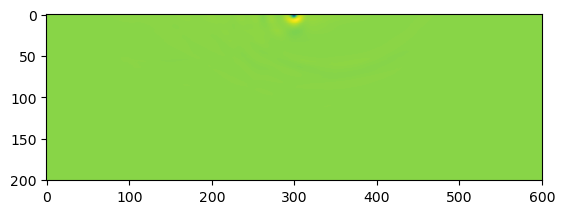

In [4]:
plt.imshow(g)